In [33]:
import vector
from tqdm.auto import tqdm
import awkward as ak

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

import numpy as np

import glob

prcoesses = {
    'cms_pf_ttbar': 't'+r'$\bar{t}$+PU'+'\nPU 55-75',
    'cms_pf_qcd': 'QCD $p_{T}\in$[15, 3000] GeV\nPU 55-75',
    'cms_pf_ztt': r'$Z\rightarrow \tau\tau$'+'\nPU 55-75'
}

which_process = 'cms_pf_ztt'

#modify path as appropriate
files = glob.glob(f'../preds_checkpoint-08-3.863894/{which_process}/*parquet')[:500]
arr = ak.concatenate([ak.from_parquet(file) for file in tqdm(files)])

  0%|          | 0/500 [00:00<?, ?it/s]

In [34]:
particle_types = {
    'ch. had.': 1,
    'n. had.': 2,
    '$e^\pm$': 6,
    '$\mu^\pm$': 7,
    '$\gamma$': 5,
    'hf had.': 3,
    'hf e.m.': 4,
}

particle_types_literal = {
    'ch. had.': 'chhad',
    'n. had.': 'nhad',
    '$e^\pm$': 'e',
    '$\mu^\pm$': 'mu',
    '$\gamma$': 'gamma',
    'hf had.': 'hfhad',
    'hf e.m.': 'hfem',
}


pu_target_pred = {}

for particle_type in particle_types:
    sel = (arr.particles.target.cls_id == particle_types[particle_type])
    pu_target_pred[particle_type] = [arr.particles.target[sel].ispu, arr.particles.pred[sel].ispu]

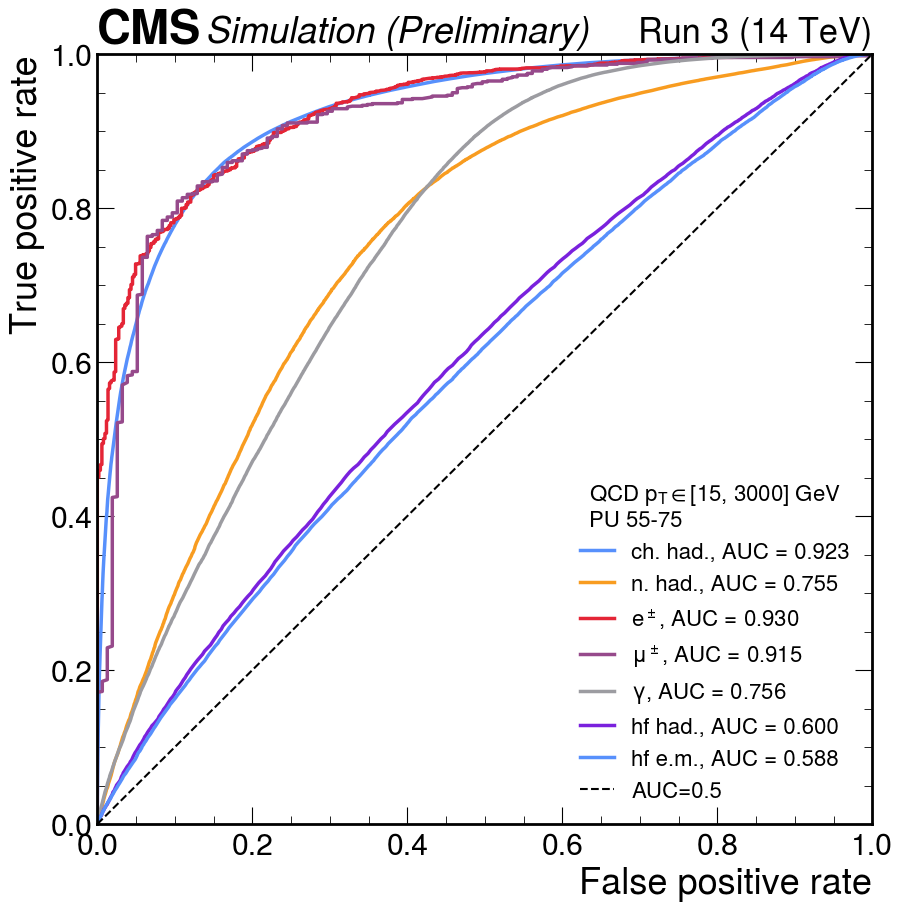

In [27]:
import mplhep as hep

plt.style.use(hep.style.CMS)

for particle_type in pu_target_pred:
    fpr, tpr, thresholds = roc_curve(ak.flatten(pu_target_pred[particle_type][0]) == 1, ak.flatten(pu_target_pred[particle_type][1]))
    auc = roc_auc_score(ak.flatten(pu_target_pred[particle_type][0]) == 1, ak.flatten(pu_target_pred[particle_type][1]))
    
    plt.plot(fpr, tpr, label = particle_type+', AUC = %0.3f' % auc, linewidth=2.5)

plt.plot([0, 1], [0, 1],'k--', label='AUC=0.5')
plt.legend(loc = 'lower right', frameon=False, title=prcoesses[which_process], fontsize=16, title_fontsize=16)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True positive rate', loc='top')
plt.xlabel('False positive rate', loc='right')

hep.cms.label("(Preliminary)", data=False, com=14, year='Run 3')

#modify path as appropriate
plt.savefig(f'pu_performance/{which_process}_pu_roc.pdf')

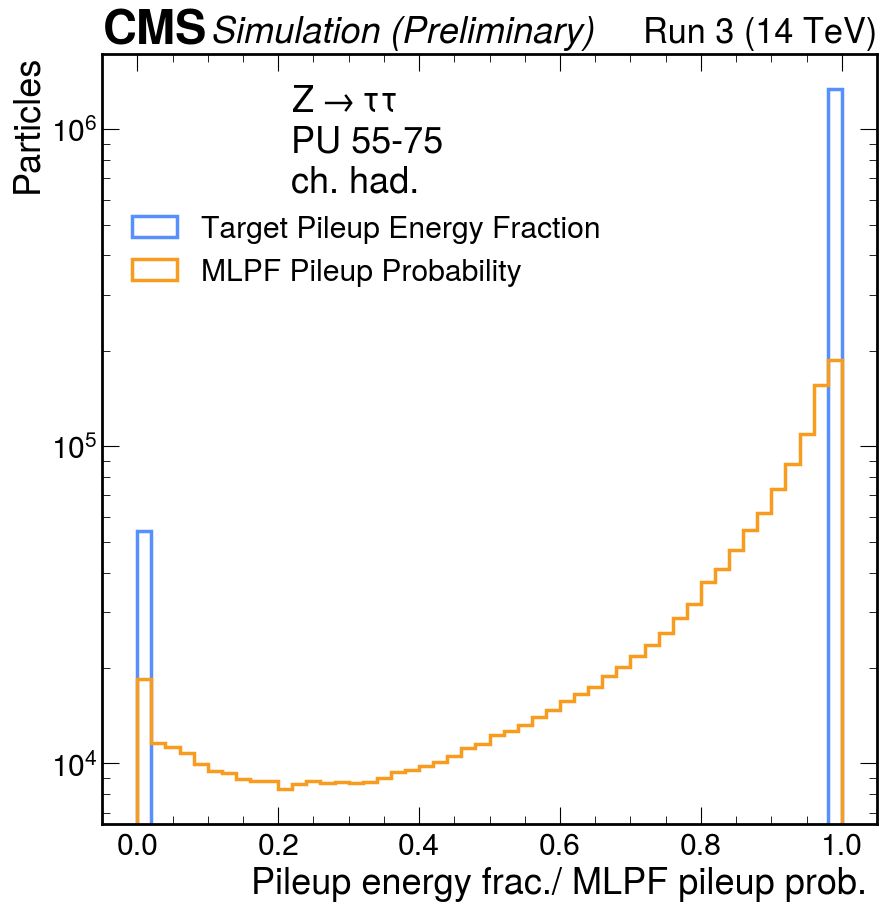

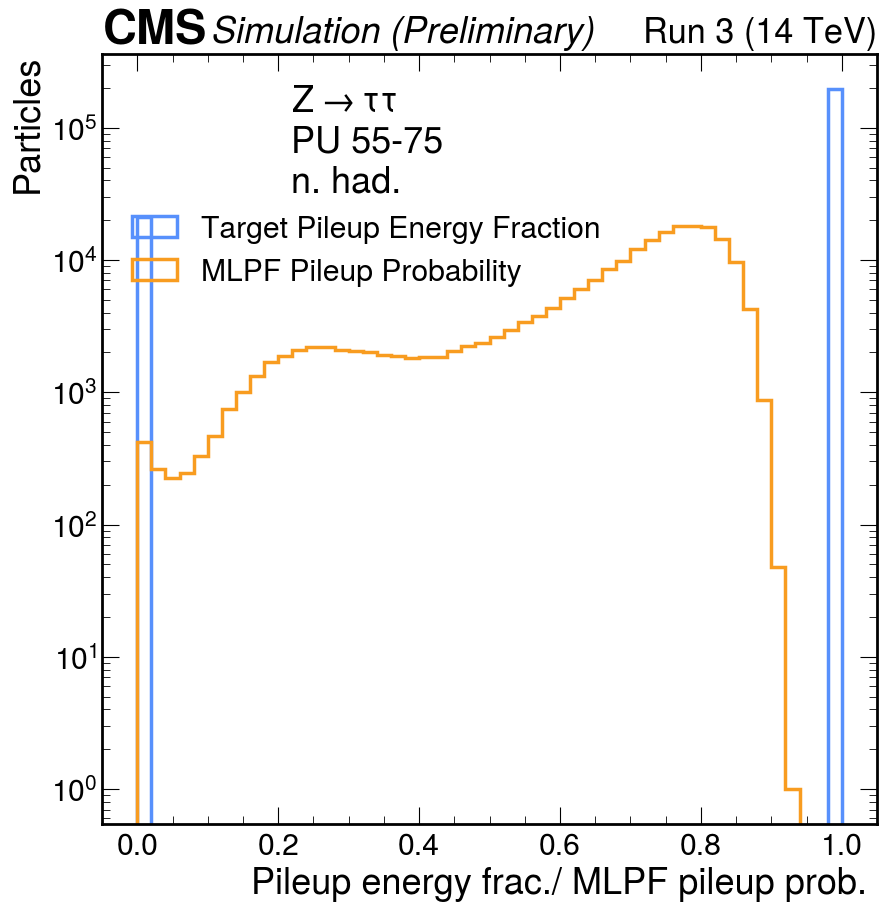

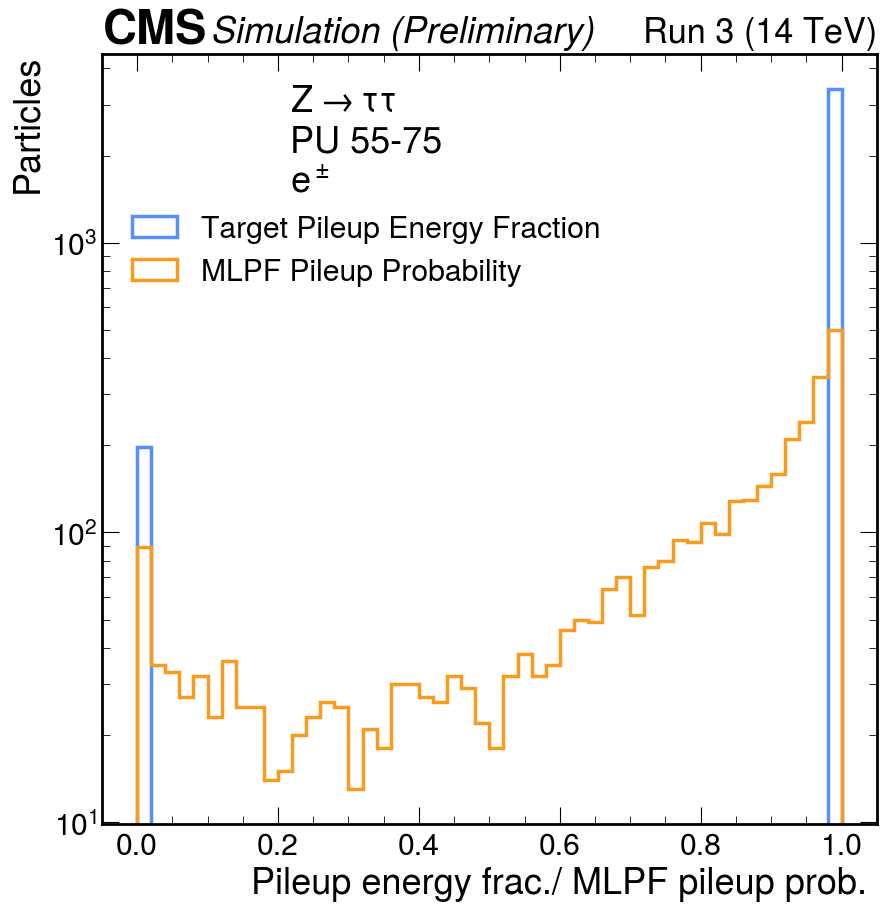

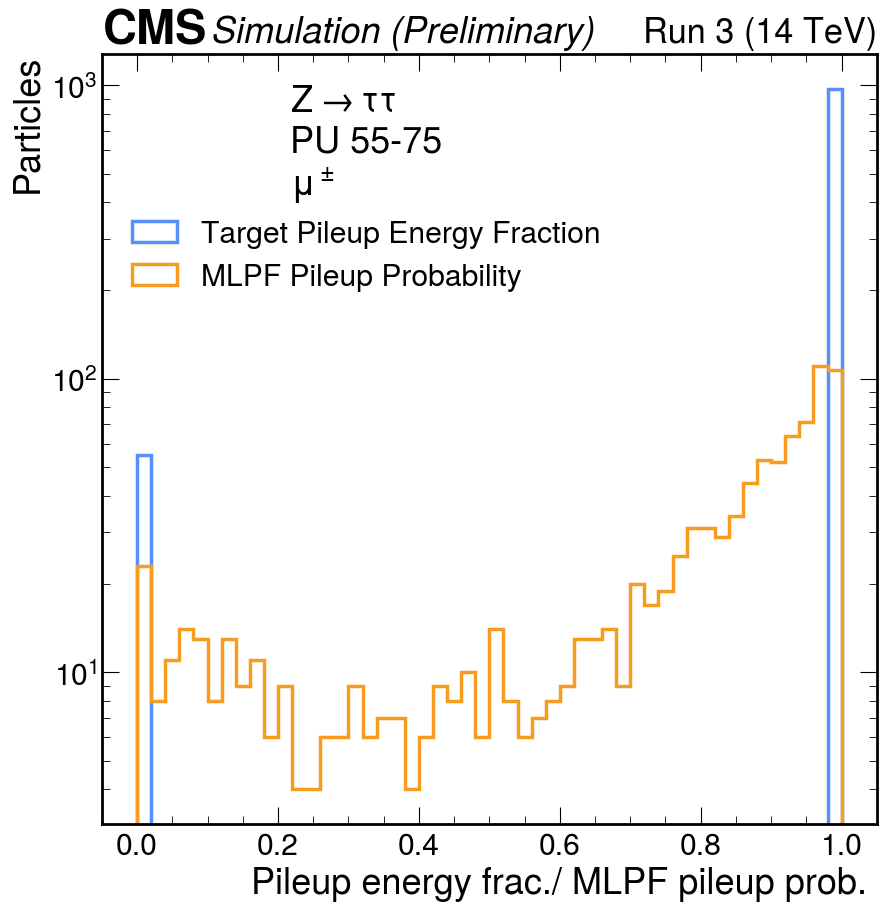

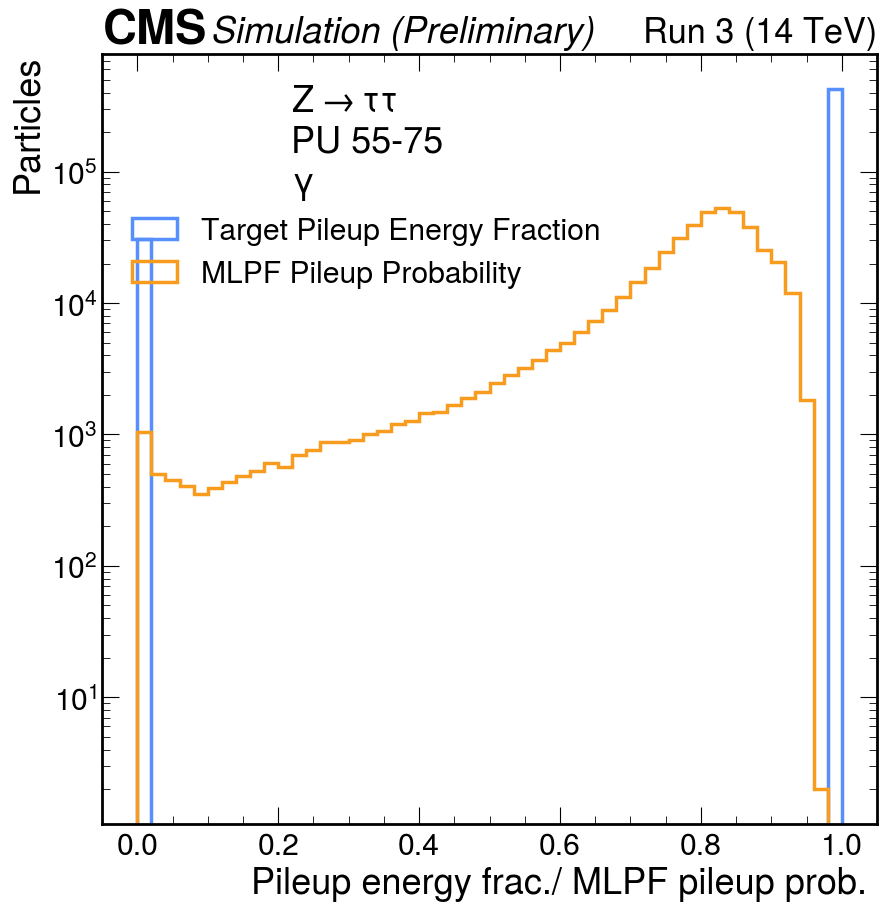

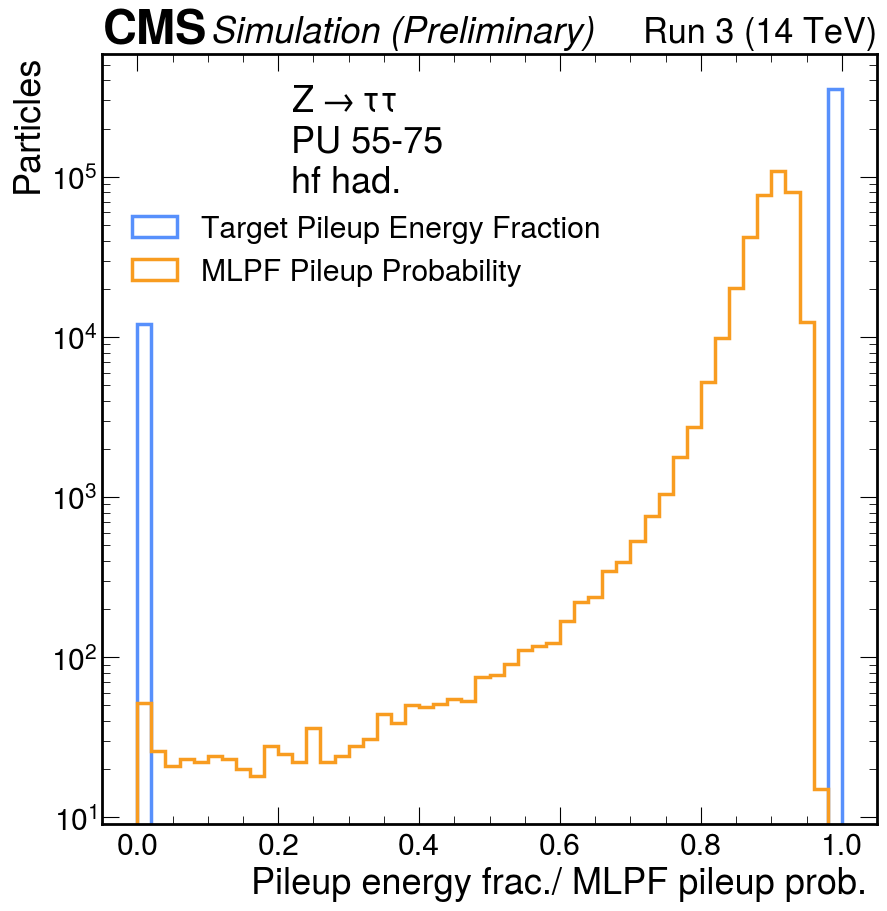

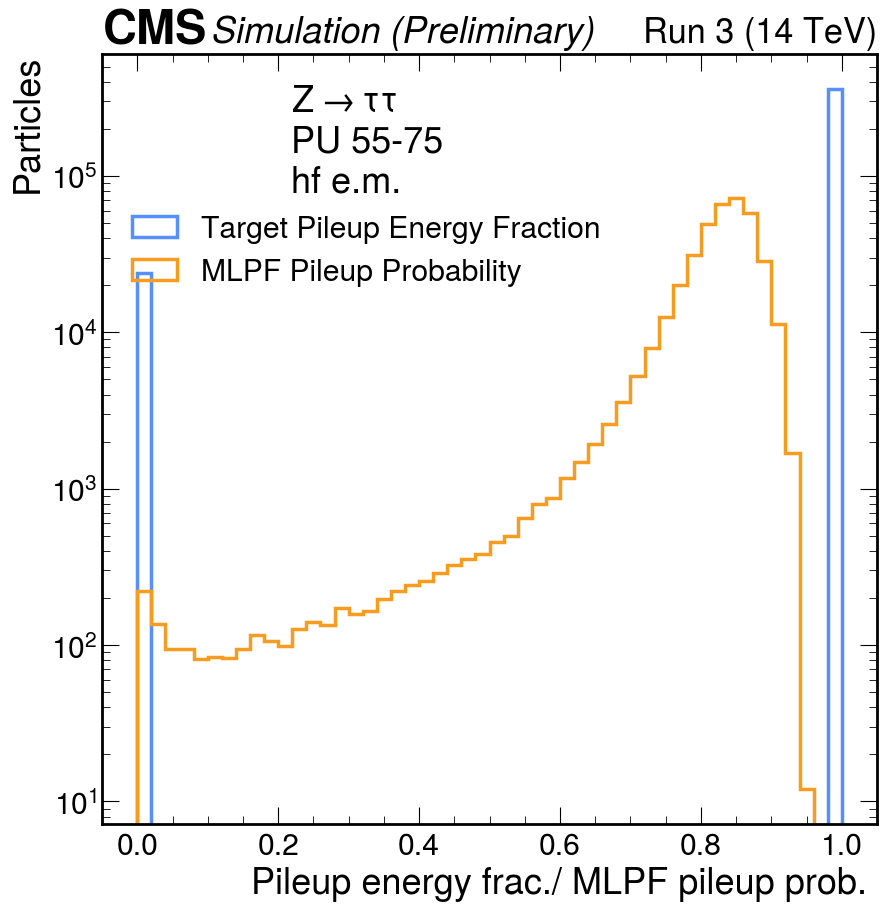

In [35]:
for particle_type in pu_target_pred:

    plt.style.use(hep.style.CMS)

    fig = plt.figure()
    ax = plt.gca()
    
    plt.hist(ak.flatten(pu_target_pred[particle_type][0]), histtype='step', bins=50, range=(0, 1), label='Target Pileup Energy Fraction', linewidth=2.5)
    plt.hist(ak.flatten(pu_target_pred[particle_type][1]), histtype='step', bins=50, range=(0, 1), label='MLPF Pileup Probability', linewidth=2.5)

    ax.set_yscale('log')
    ax.set_xlabel("Pileup energy frac./ MLPF pileup prob. ", loc='right')
    ax.set_ylabel('Particles', loc='top')

    hep.cms.label("(Preliminary) ", data=False, com=14, year='Run 3')
    
    plt.legend(title=prcoesses[which_process]+'\n'+particle_type, frameon=False, loc='upper left')
    
    #modify path as appropriate
    plt.savefig(f'pu_performance/{which_process}_{particle_types_literal[particle_type]}_pu.pdf')